In [1]:
''' basic package '''
import os
# 告訴系統要第幾張卡被看到。 Ex. 硬體總共有8張顯卡，以下設定只讓系統看到第1張顯卡
# 若沒設定，則 Tensorflow 在運行時，預設會把所有卡都佔用
# 要看裝置內顯卡數量及目前狀態的話，請在終端機內輸入 "nvidia-smi"
# 若你的裝置只有一張顯卡可以使用，可以忽略此設定
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

''' tensorflow package '''
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data


# Config

In [2]:
batch_size = 128
lr = 1e-4
clip= [-0.01, 0.01]
Z_dim = 100        # demesion of noise vector z for generator input
max_iter = 10000
d_update_cycle = 5
mnist = input_data.read_data_sets('//data/examples/MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting //data/examples/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting //data/examples/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting //data/examples/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting //data/examples/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### 定義 generator & discriminator 

In [3]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

#### Define model ####
def generator(z):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):  
        with tf.variable_scope('hidden_layer'):
            g_w1 = tf.get_variable(name="weight_1", dtype=tf.float32, initializer=xavier_init([100, 128]))
            g_b1 = tf.get_variable(name="bias_1", dtype=tf.float32, initializer=tf.zeros(shape=[128]))
            g_h1 = tf.nn.relu(tf.matmul(z, g_w1) + g_b1)
            
        with tf.variable_scope('output_layer'):
            g_w2 = tf.get_variable(name="weight_2", dtype=tf.float32, initializer=xavier_init([128, 784]))
            g_b2 = tf.get_variable(name="bias_2", dtype=tf.float32, initializer=tf.zeros(shape=[784]))
            g_prob = tf.nn.sigmoid(tf.matmul(g_h1, g_w2) + g_b2)
                       
    return g_prob

def discriminator(x):
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
        with tf.variable_scope('hidden_layer'):
            d_w1 = tf.get_variable(name="weight_1", dtype=tf.float32, initializer=xavier_init([784, 128]))
            d_b1 = tf.get_variable(name="bias_1", dtype=tf.float32, initializer=tf.zeros(shape=[128]))
            d_h1 = tf.nn.relu(tf.matmul(x, d_w1) + d_b1)
            
        with tf.variable_scope('output_layer'):
            d_w2 = tf.get_variable(name="weight_2", dtype=tf.float32, initializer=xavier_init([128, 1]))
            d_b2 = tf.get_variable(name="bias_2", dtype=tf.float32, initializer=tf.zeros(shape=[1]))
            d_logit = tf.matmul(d_h1, d_w2) + d_b1
#             d_prob = tf.nn.sigmoid(d_logit)
            
    return d_logit

### Tensorflow- 建立靜態圖 

**靜態圖**就像一張計畫圖一樣，定義我們的計算流程。實際運算必須靠 **<span style="color:red;"> Session </span>** 來執行



In [4]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    
    #### placeholder ####
    Z = tf.placeholder(name='z', dtype=tf.float32, shape=[None, 100])
    input_img = tf.placeholder(name='real_img', dtype=tf.float32, shape=[None, 784])

    #### GAN model output ####  
    g_sample = generator(Z)
    d_logit_fake = discriminator(g_sample)
    d_logit_real = discriminator(input_img)

    #### loss ####
    d_loss_real = tf.reduce_mean(tf.scalar_mul(-1, d_logit_real))
    d_loss_fake = tf.reduce_mean(d_logit_fake)
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.scalar_mul(-1, d_logit_fake))

    #### variable list ####
    varList = tf.trainable_variables()
    g_varList = [var for var in varList if 'generator' in var.name]
    d_varList = [var for var in varList if 'discriminator' in var.name]
    
    #### update ####
    d_optimizer = tf.train.RMSPropOptimizer(lr).minimize(d_loss, var_list=d_varList)
    g_optimizer = tf.train.RMSPropOptimizer(lr).minimize(g_loss, var_list=g_varList)
    
    clip_d_optimizer = [var.assign(tf.clip_by_value(var, clip[0], clip[1])) for var in d_varList]

    init = tf.global_variables_initializer()

### Tensorflow- 初始化模型

In [5]:
#### initialize model ####
sess.run(init)

### Tensorflow- 實際執行模型訓練

In [6]:
def sample_Z(m, n):
    return np.random.uniform(-1, 1, size=[m, n])

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
        
    return fig

# WGAN：先訓練discriminator並使用weight clipping n次，在訓練一次generator

Iter: 0
D loss: 0.003815
G_loss: -0.007782


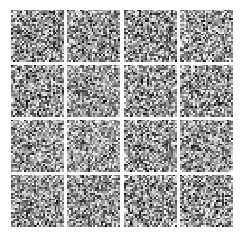

############################
Iter: 1000
D loss: -0.0556
G_loss: 0.01842


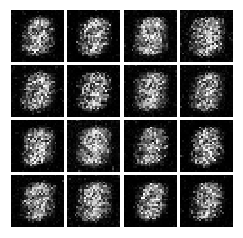

############################
Iter: 2000
D loss: 0.001067
G_loss: -0.07258


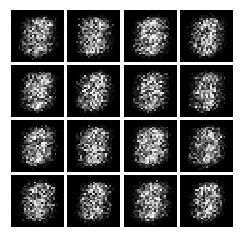

############################
Iter: 3000
D loss: -0.002049
G_loss: -0.04085


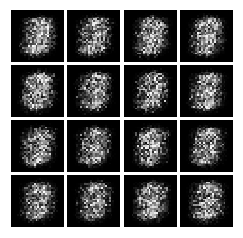

############################
Iter: 4000
D loss: -0.006178
G_loss: -0.07557


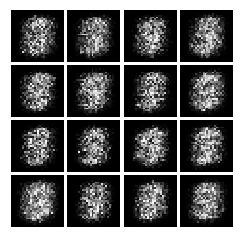

############################
Iter: 5000
D loss: -0.08299
G_loss: -0.007136


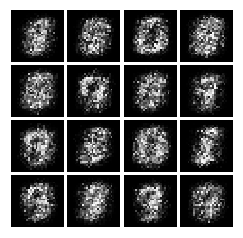

############################
Iter: 6000
D loss: -0.06235
G_loss: -0.01225


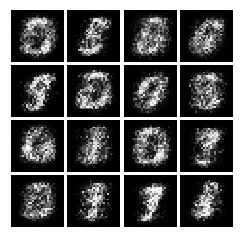

############################
Iter: 7000
D loss: -0.04266
G_loss: -0.006758


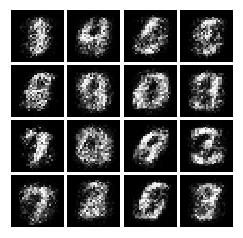

############################
Iter: 8000
D loss: -0.04094
G_loss: -0.001272


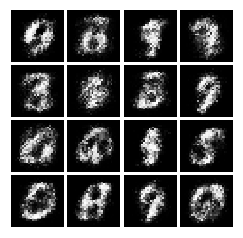

############################
Iter: 9000
D loss: -0.02882
G_loss: -0.00767


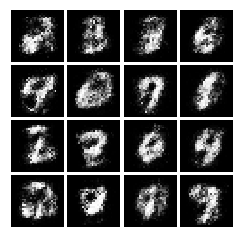

############################


In [7]:
from tqdm import tqdm_notebook
bar = tqdm_notebook(range(max_iter), leave=False)
for it in bar:
    
    for _ in range(d_update_cycle):
        X, _ = mnist.train.next_batch(batch_size)
        _, d_loss_curr = sess.run([d_optimizer, d_loss], feed_dict={input_img: X, Z: sample_Z(batch_size, Z_dim)})
        sess.run([clip_d_optimizer])
    _, g_loss_curr = sess.run([g_optimizer, g_loss], feed_dict={Z: sample_Z(batch_size, Z_dim)})
    
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(d_loss_curr))
        print('G_loss: {:.4}'.format(g_loss_curr))
                                     
        samples = sess.run(g_sample, feed_dict={Z: sample_Z(16, Z_dim)})
        fig = plot(samples)
        plt.show()
        plt.close(fig)
        print('############################')        